In [57]:
import os, glob, random
import numpy as np
import scipy.io as sio
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

def first_data_key(matdict: dict) -> str:
    for k in matdict.keys():
        if not k.startswith("__"): return k
    raise KeyError("No data key found")

def _to_complex64(x: torch.Tensor) -> torch.Tensor:
    if torch.is_complex(x): return x.to(torch.complex64)
    return x.to(torch.float32).to(torch.complex64)

def cplx_to_2ch(x: torch.Tensor) -> torch.Tensor:
    x = _to_complex64(x)
    return torch.stack([x.real.float(), x.imag.float()], dim=0)

def magnitude_01(x2: torch.Tensor) -> torch.Tensor:
    # x2: (B,2,H,W) -> (B,1,H,W) in [0,1] for preview only
    mag = torch.sqrt(x2[:,0]**2 + x2[:,1]**2)
    eps = 1e-8
    q = torch.quantile(mag.view(mag.size(0), -1), 0.999, dim=1, keepdim=True).clamp_min(eps)
    mag = (mag / q.view(-1,1,1)).clamp(0,1)
    return mag.unsqueeze(1)


class SPENUnpairedDataset(Dataset):
    """
    Expects:
      <root>/data/*.mat              (HR domain B)
      <root>/<lr_dir>/*.mat          (LR domain A, complex)
    Returns:
      'A' = random LR (2ch), 'B' = random HR (2ch), no alignment.
    """
    def __init__(self, root: str, lr_dir: str = "final_rxyacq_ROFFT"):
        self.root = root
        self.lr_dir = lr_dir

        self.hr_files = sorted(glob.glob(os.path.join(root, "data", "*.mat")))
        self.lr_files = sorted(glob.glob(os.path.join(root, lr_dir, "*.mat")))
        if len(self.hr_files) == 0: raise FileNotFoundError(f"No HR .mat in {os.path.join(root,'data')}")
        if len(self.lr_files) == 0: raise FileNotFoundError(f"No LR .mat in {os.path.join(root,lr_dir)}")
        self.rng = random.Random(1234)

    @staticmethod
    def _load_mat(path: str) -> np.ndarray:
        d = sio.loadmat(path)
        return np.squeeze(np.asarray(d[first_data_key(d)]))

    @staticmethod
    def _np_to_torch_complex(arr: np.ndarray) -> torch.Tensor:
        if np.iscomplexobj(arr): return torch.from_numpy(arr).to(torch.complex64)
        return torch.from_numpy(arr.astype(np.float32)).to(torch.complex64)

    def __len__(self):
        # follow CycleGAN: iterate by the larger domain
        return max(len(self.lr_files), len(self.hr_files))

    def __getitem__(self, idx):
        # sample independently (unpaired)
        lr_path = self.lr_files[self.rng.randrange(len(self.lr_files))]
        hr_path = self.hr_files[self.rng.randrange(len(self.hr_files))]

        lr = self._np_to_torch_complex(self._load_mat(lr_path))  # (H,W) complex
        hr = self._np_to_torch_complex(self._load_mat(hr_path))

        A = cplx_to_2ch(lr)  # (2,H,W)
        B = cplx_to_2ch(hr)


        # synthesize IDs from filenames (for logging only)
        idA = os.path.splitext(os.path.basename(lr_path))[0]
        idB = os.path.splitext(os.path.basename(hr_path))[0]
        return {"A": A, "B": B, "idA": idA, "idB": idB}

In [58]:
dt = SPENUnpairedDataset("/home/data1/musong/workspace/2025/8/08-20/tr/data/IXI_sim")

In [59]:
idx = 10
dt[idx].keys()

dict_keys(['A', 'B', 'idA', 'idB'])

IXI317-Guys-0896-T1_idx0052
IXI132-HH-1415-T1_idx0006


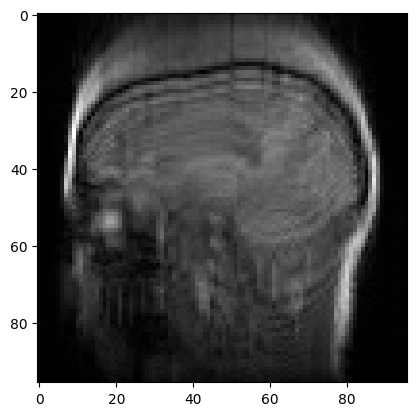

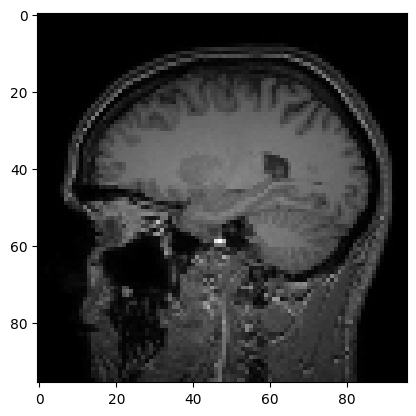

In [64]:
idx = 190
data = dt[idx]['A']
plt.figure()
plt.imshow(torch.sqrt(data[0] ** 2 + data[1] ** 2), cmap='gray')
print(dt[idx]['idA'])
plt.figure()
plt.imshow(dt[idx]['B'][0], cmap='gray')
print(dt[idx]['idB'])